<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [15]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 

# *********************************************************************** #
#                           Hyper parameters
# *********************************************************************** #

BATCH_SIZE = 3
NUM_EPOCHS = 20
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers


# *********************************************************************** #
#                             Dataset
# *********************************************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)
print()

def remove_consecutively_repeated(sequence):
  """
  Receives list of labels and remove the ones that are repeated consecutively
  
  E.g. [27 27 28 28 28] -> [27, 28]

  """
  diff = np.diff(sequence).astype(np.bool)
  idx = np.insert(diff, 0, True)
  sequence_reduced = sequence[idx]

  return sequence_reduced


def collate_timit(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    input_lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequences to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Get batched input
    x_batch = batch_padded[:,:,:-1]
    
    # Obtain targets
    y_batch = [seq[:,-1] for seq in batch]

    # Remove repeated consecutive labels in target sequences: (E.g. [27 27 28 28 28 61] -> [27 28 61])
    # NOTE: This is done to make targets shorter than input, so that nn.CTCLoss doesn't yield infinite values
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch: # Loop over each sequence
      y_seq_reduced = remove_consecutively_repeated(y_seq)
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))

    # Pad target sequences
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    
    y_batch = torch.as_tensor(y_batch_padded)
    
    return x_batch, y_batch, input_lens, target_lens


# *********************************************************************** #
#                           Model
# *********************************************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens



# *********************************************************************** #
#                           Decoding
# *********************************************************************** #

def greedy_decoding(sequences, sequence_lens, blank_label, remove_blanks=False, remove_repeated=False):
  """
  For each timestemp, takes the label with maximum probability.
  Removes blank labels if remove_blanks is set to True.

  :param sequences: torch tensor [batch, sequence len, number of classes]
  :param blank_label: blank label
  :param sequence_lens: list of sequence lengths for each sequence in batch
  :return: list of decoded sequences (different lengths).
  """

  decoded_sequences = []
  for sequence, seq_len in zip(sequences, sequence_lens):
    seq = sequence[:seq_len]  # Remove pads
    decoded_seq = torch.argmax(seq, dim=1)
    
    if remove_repeated:
      decoded_seq = remove_consecutively_repeated(decoded_seq.cpu())
      decoded_seq = decoded_seq.to(dev)
      

    if remove_blanks:
      decoded_seq = decoded_seq[decoded_seq != blank_label]

    decoded_sequences.append(decoded_seq)

  return decoded_sequences


def print_distances(distances, token1Length, token2Length):
  for t1 in range(token1Length + 1):
      for t2 in range(token2Length + 1):
          print(int(distances[t1][t2]), end=" ")
      print()

def levenshtein_distance(token1, token2, debug=False):
  """
  Computes the Edit Distance between two sequences.
  """
  distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
        
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
          distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
          a = distances[t1][t2 - 1]
          b = distances[t1 - 1][t2]
          c = distances[t1 - 1][t2 - 1]             
          min_dist = min((a,b,c))

          distances[t1][t2] = min_dist + 1

  if debug:
    print_distances(distances, len(token1), len(token2))
    
  return distances[len(token1)][len(token2)]


def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens, debug=False):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist

  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)*100 # Although LER it's not a real percentage, as it could be > %100
  
  if debug:
    print("Total distance ", total_distance)
    print("Target total len ", target_total_len)

  return label_err_rate


# *********************************************************************** #
#                        Train & Test functions
# *********************************************************************** #

def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      predictions = greedy_decoding(model_out, input_lens, blank_label=BLANK_LABEL, 
                                    remove_blanks=True, remove_repeated=True)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  print(label_err_rates)
  print(avg_label_err_rate)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919

Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
100.0
---- Training results ----
Loss: 1.3370336647028531
---- Test results ----
Loss: 1.240880270799001
Label error rate: 100.0

Epoch nr:  2



[100.0, 100.0, 98.71794871794873, 100.0, 100.0, 98.52941176470588, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.0909090909091, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.375, 100.0, 100.0, 100.0, 100.0, 100.0]
99.93301983708693
---- Training results ----
Loss: 1.0825633652411497
---- Test results ----
Loss: 0.9508485334614912
Label error rate: 99.93301983708693

Epoch nr:  3



[80.7017543859649, 82.35294117647058, 70.51282051282051, 70.3125, 70.66666666666667, 66.17647058823529, 68.67469879518072, 73.91304347826086, 70.58823529411765, 72.72727272727273, 77.77777777777779, 70.58823529411765, 75.0, 75.9493670886076, 73.62637362637363, 78.88888888888889, 73.33333333333333, 70.0, 69.1358024691358, 78.75, 80.68181818181817, 67.85714285714286, 72.81553398058253, 71.96261682242991, 73.87387387387388, 77.77777777777779, 77.55102040816327, 76.40449438202246, 80.9090909090909, 77.5, 78.78787878787878, 73.68421052631578, 76.06837606837607, 75.45454545454545, 75.51020408163265, 72.3404255319149, 75.65217391304347, 79.83193277310924, 75.0, 75.23809523809524, 71.66666666666667, 74.81481481481481, 82.8125, 74.77477477477478, 74.60317460317461, 69.85294117647058, 81.73076923076923, 74.21875, 74.80314960629921, 72.85714285714285, 71.69811320754717, 76.47058823529412, 74.23312883435584, 76.25, 77.01863354037268, 79.05405405405406, 73.68421052631578, 76.66666666666667, 71.875


[68.42105263157895, 52.94117647058824, 56.41025641025641, 46.875, 53.333333333333336, 38.23529411764706, 55.42168674698795, 50.0, 54.41176470588235, 43.18181818181818, 48.484848484848484, 47.05882352941176, 55.434782608695656, 58.22784810126582, 47.25274725274725, 47.77777777777778, 53.333333333333336, 47.27272727272727, 54.32098765432099, 55.00000000000001, 54.54545454545454, 45.535714285714285, 48.54368932038835, 51.4018691588785, 54.95495495495496, 48.484848484848484, 48.97959183673469, 53.93258426966292, 56.36363636363636, 52.5, 50.505050505050505, 47.368421052631575, 54.700854700854705, 47.27272727272727, 39.795918367346935, 47.5177304964539, 55.65217391304348, 48.739495798319325, 54.310344827586206, 46.666666666666664, 49.166666666666664, 51.11111111111111, 55.46875, 46.846846846846844, 44.44444444444444, 47.794117647058826, 55.769230769230774, 42.1875, 55.90551181102362, 49.28571428571429, 42.76729559748428, 52.10084033613446, 57.05521472392638, 51.24999999999999, 50.3105590062


[68.42105263157895, 50.98039215686274, 52.56410256410257, 39.0625, 48.0, 36.76470588235294, 49.39759036144578, 45.65217391304348, 47.05882352941176, 42.04545454545455, 46.464646464646464, 46.07843137254902, 50.0, 45.56962025316456, 45.05494505494506, 43.333333333333336, 38.095238095238095, 39.09090909090909, 41.9753086419753, 45.0, 50.0, 39.285714285714285, 46.601941747572816, 44.85981308411215, 47.74774774774775, 38.38383838383838, 48.97959183673469, 43.82022471910113, 43.63636363636363, 46.666666666666664, 45.45454545454545, 42.10526315789473, 52.13675213675214, 39.09090909090909, 38.775510204081634, 41.843971631205676, 44.34782608695652, 41.17647058823529, 48.275862068965516, 45.714285714285715, 45.83333333333333, 43.7037037037037, 53.90625, 37.83783783783784, 34.92063492063492, 44.85294117647059, 42.30769230769231, 41.40625, 48.818897637795274, 42.857142857142854, 40.25157232704403, 49.57983193277311, 51.533742331288344, 46.25, 45.3416149068323, 51.35135135135135, 43.4210526315789


[63.1578947368421, 41.17647058823529, 41.02564102564102, 39.0625, 45.33333333333333, 36.76470588235294, 44.57831325301205, 42.391304347826086, 44.11764705882353, 34.090909090909086, 43.43434343434344, 43.13725490196079, 46.73913043478261, 48.10126582278481, 39.56043956043956, 44.44444444444444, 36.19047619047619, 38.18181818181819, 41.9753086419753, 47.5, 44.31818181818182, 36.607142857142854, 36.89320388349515, 44.85981308411215, 49.549549549549546, 38.38383838383838, 46.93877551020408, 41.57303370786517, 42.72727272727273, 45.83333333333333, 47.474747474747474, 37.719298245614034, 49.572649572649574, 40.0, 36.734693877551024, 42.5531914893617, 40.0, 42.857142857142854, 44.827586206896555, 44.761904761904766, 39.166666666666664, 47.40740740740741, 52.34375, 36.03603603603604, 39.682539682539684, 44.11764705882353, 45.19230769230769, 39.0625, 44.09448818897638, 40.0, 37.10691823899371, 45.378151260504204, 48.466257668711656, 48.125, 45.3416149068323, 47.2972972972973, 44.7368421052631


[66.66666666666666, 45.09803921568628, 37.17948717948718, 40.625, 42.66666666666667, 36.76470588235294, 44.57831325301205, 41.30434782608695, 41.17647058823529, 35.22727272727273, 41.41414141414141, 40.19607843137255, 43.47826086956522, 44.303797468354425, 40.65934065934066, 41.11111111111111, 34.285714285714285, 44.54545454545455, 37.03703703703704, 40.0, 45.45454545454545, 35.714285714285715, 33.00970873786408, 38.31775700934579, 45.94594594594595, 36.36363636363637, 43.87755102040816, 31.46067415730337, 44.54545454545455, 44.166666666666664, 44.44444444444444, 34.21052631578947, 48.717948717948715, 33.63636363636363, 35.714285714285715, 39.00709219858156, 44.34782608695652, 43.69747899159664, 43.96551724137931, 40.0, 35.0, 43.7037037037037, 48.4375, 39.63963963963964, 38.095238095238095, 40.44117647058824, 45.19230769230769, 35.9375, 45.66929133858268, 36.42857142857142, 38.36477987421384, 47.89915966386555, 48.466257668711656, 47.5, 40.993788819875775, 45.27027027027027, 38.157894


[63.1578947368421, 43.13725490196079, 37.17948717948718, 39.0625, 34.66666666666667, 25.0, 39.75903614457831, 35.869565217391305, 36.76470588235294, 30.681818181818183, 38.38383838383838, 35.294117647058826, 43.47826086956522, 31.645569620253166, 39.56043956043956, 37.77777777777778, 32.38095238095238, 35.45454545454545, 38.2716049382716, 37.5, 39.77272727272727, 33.035714285714285, 33.00970873786408, 39.25233644859813, 42.34234234234234, 36.36363636363637, 35.714285714285715, 29.213483146067414, 37.27272727272727, 43.333333333333336, 42.42424242424242, 35.96491228070175, 47.008547008547005, 32.72727272727273, 34.69387755102041, 34.751773049645394, 43.47826086956522, 39.49579831932773, 43.103448275862064, 39.04761904761905, 32.5, 39.25925925925926, 51.5625, 37.83783783783784, 33.33333333333333, 33.82352941176471, 38.46153846153847, 32.8125, 44.09448818897638, 38.57142857142858, 34.59119496855346, 47.89915966386555, 44.785276073619634, 43.75, 40.37267080745342, 45.94594594594595, 38.81


[57.89473684210527, 39.21568627450981, 37.17948717948718, 43.75, 34.66666666666667, 29.411764705882355, 43.373493975903614, 35.869565217391305, 39.705882352941174, 30.681818181818183, 38.38383838383838, 33.33333333333333, 44.565217391304344, 31.645569620253166, 38.46153846153847, 36.666666666666664, 30.476190476190478, 33.63636363636363, 35.80246913580247, 33.75, 35.22727272727273, 28.57142857142857, 33.00970873786408, 38.31775700934579, 39.63963963963964, 33.33333333333333, 34.69387755102041, 33.70786516853933, 34.54545454545455, 41.66666666666667, 43.43434343434344, 33.33333333333333, 47.008547008547005, 33.63636363636363, 31.63265306122449, 34.751773049645394, 43.47826086956522, 36.97478991596639, 37.06896551724138, 33.33333333333333, 31.666666666666664, 38.51851851851852, 50.78125, 34.234234234234236, 37.301587301587304, 33.82352941176471, 36.53846153846153, 32.03125, 43.30708661417323, 35.0, 33.33333333333333, 42.857142857142854, 44.785276073619634, 41.25, 42.2360248447205, 43.24


[61.40350877192983, 49.01960784313725, 33.33333333333333, 45.3125, 32.0, 25.0, 42.168674698795186, 34.78260869565217, 44.11764705882353, 32.95454545454545, 38.38383838383838, 32.35294117647059, 41.30434782608695, 35.44303797468354, 40.65934065934066, 40.0, 28.57142857142857, 35.45454545454545, 33.33333333333333, 36.25, 43.18181818181818, 29.464285714285715, 30.097087378640776, 37.38317757009346, 44.14414414414414, 36.36363636363637, 34.69387755102041, 30.337078651685395, 32.72727272727273, 37.5, 42.42424242424242, 34.21052631578947, 45.2991452991453, 36.36363636363637, 29.591836734693878, 35.46099290780142, 47.82608695652174, 37.81512605042017, 40.51724137931034, 38.095238095238095, 32.5, 40.74074074074074, 50.0, 34.234234234234236, 34.12698412698413, 35.294117647058826, 34.61538461538461, 35.15625, 43.30708661417323, 32.142857142857146, 33.9622641509434, 44.537815126050425, 46.012269938650306, 38.75, 39.130434782608695, 42.567567567567565, 34.868421052631575, 44.0, 33.75, 33.72093023


[59.64912280701754, 43.13725490196079, 41.02564102564102, 35.9375, 30.666666666666664, 29.411764705882355, 37.34939759036144, 34.78260869565217, 41.17647058823529, 28.40909090909091, 39.39393939393939, 37.254901960784316, 41.30434782608695, 30.37974683544304, 35.16483516483517, 36.666666666666664, 29.523809523809526, 32.72727272727273, 37.03703703703704, 32.5, 35.22727272727273, 31.25, 32.038834951456316, 40.18691588785047, 40.54054054054054, 35.35353535353536, 33.6734693877551, 30.337078651685395, 36.36363636363637, 38.333333333333336, 40.4040404040404, 31.57894736842105, 42.73504273504273, 38.18181818181819, 33.6734693877551, 34.04255319148936, 44.34782608695652, 37.81512605042017, 36.206896551724135, 32.38095238095238, 32.5, 37.77777777777778, 47.65625, 29.72972972972973, 33.33333333333333, 30.14705882352941, 35.57692307692308, 35.15625, 45.66929133858268, 34.285714285714285, 33.33333333333333, 41.17647058823529, 44.785276073619634, 40.625, 39.75155279503105, 42.567567567567565, 32


[59.64912280701754, 43.13725490196079, 37.17948717948718, 35.9375, 30.666666666666664, 23.52941176470588, 36.144578313253014, 32.608695652173914, 45.588235294117645, 29.545454545454547, 36.36363636363637, 33.33333333333333, 43.47826086956522, 31.645569620253166, 40.65934065934066, 36.666666666666664, 29.523809523809526, 30.0, 33.33333333333333, 31.25, 44.31818181818182, 32.142857142857146, 28.155339805825243, 35.51401869158878, 42.34234234234234, 31.313131313131315, 31.63265306122449, 29.213483146067414, 30.0, 36.666666666666664, 41.41414141414141, 30.701754385964914, 42.73504273504273, 30.909090909090907, 35.714285714285715, 31.914893617021278, 40.869565217391305, 35.294117647058826, 37.06896551724138, 33.33333333333333, 30.833333333333336, 37.77777777777778, 44.53125, 31.53153153153153, 33.33333333333333, 28.676470588235293, 34.61538461538461, 32.8125, 41.732283464566926, 29.28571428571429, 29.559748427672954, 42.857142857142854, 46.012269938650306, 40.0, 35.40372670807454, 40.54054


[56.14035087719298, 43.13725490196079, 35.8974358974359, 34.375, 28.000000000000004, 27.941176470588236, 38.55421686746988, 34.78260869565217, 41.17647058823529, 34.090909090909086, 31.313131313131315, 31.372549019607842, 41.30434782608695, 29.11392405063291, 36.26373626373626, 35.55555555555556, 27.61904761904762, 29.09090909090909, 34.5679012345679, 32.5, 44.31818181818182, 31.25, 26.21359223300971, 37.38317757009346, 41.44144144144144, 32.323232323232325, 28.57142857142857, 28.08988764044944, 31.818181818181817, 34.166666666666664, 40.4040404040404, 31.57894736842105, 42.73504273504273, 29.09090909090909, 32.6530612244898, 34.751773049645394, 46.95652173913044, 33.61344537815126, 38.793103448275865, 31.428571428571427, 29.166666666666668, 36.2962962962963, 44.53125, 26.126126126126124, 34.12698412698413, 30.88235294117647, 35.57692307692308, 32.03125, 37.00787401574803, 29.28571428571429, 31.446540880503143, 43.69747899159664, 43.558282208588956, 40.0, 36.64596273291926, 42.5675675


[50.877192982456144, 41.17647058823529, 32.05128205128205, 34.375, 30.666666666666664, 27.941176470588236, 34.93975903614458, 36.95652173913043, 38.23529411764706, 35.22727272727273, 30.303030303030305, 36.27450980392157, 42.391304347826086, 27.848101265822784, 38.46153846153847, 36.666666666666664, 27.61904761904762, 33.63636363636363, 34.5679012345679, 31.25, 40.909090909090914, 32.142857142857146, 28.155339805825243, 34.57943925233645, 37.83783783783784, 30.303030303030305, 31.63265306122449, 30.337078651685395, 30.909090909090907, 40.833333333333336, 40.4040404040404, 29.82456140350877, 41.02564102564102, 30.909090909090907, 30.612244897959183, 36.17021276595745, 38.26086956521739, 35.294117647058826, 39.6551724137931, 27.61904761904762, 27.500000000000004, 37.03703703703704, 42.96875, 27.027027027027028, 31.746031746031743, 30.88235294117647, 35.57692307692308, 33.59375, 38.582677165354326, 32.857142857142854, 32.70440251572327, 43.69747899159664, 45.39877300613497, 38.125, 35.40


[52.63157894736842, 45.09803921568628, 33.33333333333333, 35.9375, 28.000000000000004, 26.47058823529412, 36.144578313253014, 34.78260869565217, 36.76470588235294, 30.681818181818183, 29.292929292929294, 35.294117647058826, 42.391304347826086, 29.11392405063291, 39.56043956043956, 32.22222222222222, 30.476190476190478, 34.54545454545455, 34.5679012345679, 32.5, 40.909090909090914, 32.142857142857146, 33.980582524271846, 33.64485981308411, 39.63963963963964, 31.313131313131315, 34.69387755102041, 26.96629213483146, 30.0, 38.333333333333336, 38.38383838383838, 29.82456140350877, 41.02564102564102, 30.909090909090907, 32.6530612244898, 33.33333333333333, 40.869565217391305, 32.773109243697476, 35.3448275862069, 29.523809523809526, 31.666666666666664, 37.77777777777778, 42.1875, 29.72972972972973, 31.746031746031743, 31.61764705882353, 30.76923076923077, 32.8125, 37.79527559055118, 30.714285714285715, 32.075471698113205, 40.33613445378151, 39.263803680981596, 38.75, 36.024844720496894, 39


[47.368421052631575, 41.17647058823529, 35.8974358974359, 32.8125, 30.666666666666664, 29.411764705882355, 36.144578313253014, 32.608695652173914, 36.76470588235294, 27.27272727272727, 29.292929292929294, 33.33333333333333, 41.30434782608695, 29.11392405063291, 41.75824175824176, 34.44444444444444, 26.666666666666668, 31.818181818181817, 30.864197530864196, 27.500000000000004, 43.18181818181818, 26.785714285714285, 30.097087378640776, 36.44859813084112, 41.44144144144144, 30.303030303030305, 29.591836734693878, 25.842696629213485, 35.45454545454545, 36.666666666666664, 39.39393939393939, 32.45614035087719, 38.46153846153847, 30.909090909090907, 32.6530612244898, 37.5886524822695, 36.52173913043478, 36.134453781512605, 37.06896551724138, 29.523809523809526, 26.666666666666668, 37.03703703703704, 42.96875, 31.53153153153153, 31.746031746031743, 32.35294117647059, 31.73076923076923, 30.46875, 37.00787401574803, 30.0, 33.9622641509434, 41.17647058823529, 44.171779141104295, 40.0, 33.54037


[45.614035087719294, 45.09803921568628, 32.05128205128205, 32.8125, 26.666666666666668, 25.0, 37.34939759036144, 35.869565217391305, 42.64705882352941, 23.863636363636363, 31.313131313131315, 33.33333333333333, 41.30434782608695, 31.645569620253166, 37.362637362637365, 30.0, 27.61904761904762, 30.0, 30.864197530864196, 30.0, 43.18181818181818, 28.57142857142857, 26.21359223300971, 37.38317757009346, 37.83783783783784, 29.292929292929294, 34.69387755102041, 26.96629213483146, 30.0, 38.333333333333336, 42.42424242424242, 28.947368421052634, 40.17094017094017, 29.09090909090909, 28.57142857142857, 36.87943262411347, 38.26086956521739, 34.45378151260504, 36.206896551724135, 30.476190476190478, 20.833333333333336, 37.77777777777778, 42.96875, 27.927927927927925, 30.952380952380953, 31.61764705882353, 31.73076923076923, 28.90625, 36.22047244094488, 27.142857142857142, 31.446540880503143, 40.33613445378151, 41.104294478527606, 38.125, 37.88819875776397, 39.86486486486486, 31.57894736842105, 


[50.877192982456144, 37.254901960784316, 35.8974358974359, 32.8125, 30.666666666666664, 23.52941176470588, 30.120481927710845, 27.173913043478258, 33.82352941176471, 30.681818181818183, 31.313131313131315, 28.431372549019606, 44.565217391304344, 30.37974683544304, 39.56043956043956, 32.22222222222222, 31.428571428571427, 34.54545454545455, 34.5679012345679, 26.25, 43.18181818181818, 33.035714285714285, 29.126213592233007, 38.31775700934579, 43.24324324324324, 25.252525252525253, 33.6734693877551, 25.842696629213485, 29.09090909090909, 35.0, 40.4040404040404, 29.82456140350877, 41.88034188034188, 30.909090909090907, 30.612244897959183, 34.751773049645394, 34.78260869565217, 33.61344537815126, 40.51724137931034, 33.33333333333333, 29.166666666666668, 37.03703703703704, 45.3125, 26.126126126126124, 31.746031746031743, 31.61764705882353, 31.73076923076923, 30.46875, 33.85826771653544, 27.857142857142858, 32.075471698113205, 40.33613445378151, 43.558282208588956, 38.75, 39.130434782608695,


[49.122807017543856, 35.294117647058826, 30.76923076923077, 28.125, 24.0, 23.52941176470588, 31.32530120481928, 33.69565217391305, 33.82352941176471, 27.27272727272727, 30.303030303030305, 31.372549019607842, 41.30434782608695, 21.518987341772153, 41.75824175824176, 28.888888888888886, 29.523809523809526, 35.45454545454545, 37.03703703703704, 25.0, 44.31818181818182, 28.57142857142857, 31.06796116504854, 33.64485981308411, 41.44144144144144, 23.232323232323232, 34.69387755102041, 29.213483146067414, 25.454545454545453, 34.166666666666664, 41.41414141414141, 29.82456140350877, 39.31623931623932, 31.818181818181817, 28.57142857142857, 34.04255319148936, 35.65217391304348, 33.61344537815126, 35.3448275862069, 34.285714285714285, 22.5, 34.81481481481482, 39.84375, 29.72972972972973, 28.57142857142857, 28.676470588235293, 33.65384615384615, 30.46875, 39.37007874015748, 27.857142857142858, 30.81761006289308, 39.49579831932773, 41.104294478527606, 36.875, 38.50931677018634, 40.54054054054054


[50.877192982456144, 39.21568627450981, 30.76923076923077, 34.375, 25.333333333333336, 29.411764705882355, 27.710843373493976, 27.173913043478258, 29.411764705882355, 31.818181818181817, 27.27272727272727, 34.31372549019608, 42.391304347826086, 26.582278481012654, 36.26373626373626, 33.33333333333333, 23.809523809523807, 37.27272727272727, 32.098765432098766, 23.75, 39.77272727272727, 29.464285714285715, 23.300970873786408, 37.38317757009346, 36.93693693693694, 26.262626262626267, 34.69387755102041, 26.96629213483146, 27.27272727272727, 33.33333333333333, 42.42424242424242, 28.07017543859649, 39.31623931623932, 28.18181818181818, 33.6734693877551, 34.04255319148936, 40.0, 38.655462184873954, 37.06896551724138, 28.57142857142857, 23.333333333333332, 38.51851851851852, 40.625, 25.225225225225223, 31.746031746031743, 30.88235294117647, 33.65384615384615, 24.21875, 37.00787401574803, 32.142857142857146, 31.446540880503143, 39.49579831932773, 41.104294478527606, 38.125, 38.50931677018634, 

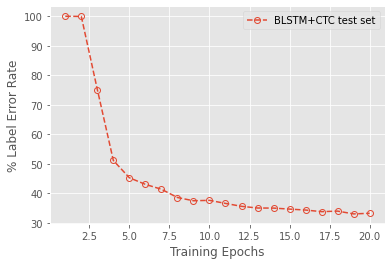

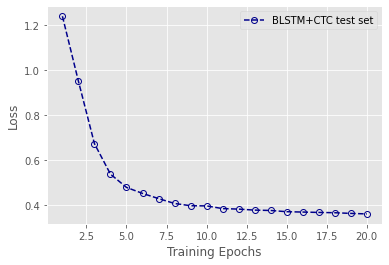

In [16]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ------------ Label error rates ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, label_error_rates, '--o', markerfacecolor='None', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'LER_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

# ------------ Losses ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, losses, '--o', markerfacecolor='None', color='darkblue', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='Loss')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'loss_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()